In [1]:
%matplotlib
#%matplotlib inline
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import folium
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify
plt.style.use('ggplot')

#defining some size for use during plots
color = (65/255,174/255,189/255)
wordcloud_size = (30,15)
barchart_size = (30,15)
fontvalue = 20

Using matplotlib backend: Qt5Agg


In [2]:
"""Merging Data Sets and creating the final DataFrame"""
#importing the CSV cleaned files (Cleaning has been done via seperate code in a seperate jupyter notebook)
Aijobsindustry_dataset = pd.read_csv("AIJobsIndustry_Clean_v3.csv")
print(f"No of rows in Aijobsindustry_dataset is {Aijobsindustry_dataset.shape[0]}")
Dice_us_jobs_dataset = pd.read_csv("Dice_US_jobs_Clean_v4.csv", encoding="cp437")
print(f"No of rows in Dice_us_jobs_dataset is {Dice_us_jobs_dataset.shape[0]}")
monster_dataset = pd.read_csv("Monster_Clean.csv")
print(f"No of rows in monster_dataset is {monster_dataset.shape[0]}")
indeed_dataset = pd.read_csv("alldata_Clean_v3.csv")
print(f"No of rows in indeed_dataset is {indeed_dataset.shape[0]}")
multi_src_dataset = pd.read_csv("cleanedandfilteredUSJobs.csv")
print(f"No of rows in multiple source data set is {multi_src_dataset.shape[0]}")
dice_tech_filtered = pd.read_csv("Dice_US_Tech_FilteredJobData.csv")
print(f"No of rows in dice_tech_filtered is {dice_tech_filtered.shape[0]}")
# Calcualting the total
print(f"No of rows in final merged data set should be {Aijobsindustry_dataset.shape[0]+multi_src_dataset.shape[0]+Dice_us_jobs_dataset.shape[0]+monster_dataset.shape[0]+indeed_dataset.shape[0]+dice_tech_filtered.shape[0]}")
datasets_to_merge = [Aijobsindustry_dataset,Dice_us_jobs_dataset,monster_dataset,indeed_dataset,dice_tech_filtered,multi_src_dataset]

# Concatenating the data sets
merged_dataset = pd.concat(datasets_to_merge, sort=False)
# Printing the actual values in the data set
print(f"Actual no of rows in merged_dataset is {merged_dataset.shape[0]}")
#Exporting the dataset
merged_dataset.to_csv('Merged_Dataset.csv')
print(merged_dataset.head())

No of rows in Aijobsindustry_dataset is 631
No of rows in Dice_us_jobs_dataset is 1265
No of rows in monster_dataset is 162
No of rows in indeed_dataset is 6953
No of rows in multiple source data set is 207
No of rows in dice_tech_filtered is 1566
No of rows in final merged data set should be 10784
Actual no of rows in merged_dataset is 10784
                                            Position     Company Description  \
0  Data Science Development Program- Junior Data ...  MassMutual         NaN   
1  Entry-Level Cognitive / AI / Machine Learning ...         IBM         NaN   
2                               PHP/MySQL Programmer         NaN         NaN   
3                              Python Programmer Job        SAIC         NaN   
4                                         BI Analyst         NaN         NaN   

  Loc_state       Loc_city Skills Type Source  
0        MA        Amherst    NaN  NaN    NaN  
1        TX         Austin    NaN  NaN    NaN  
2        TX         Austin    

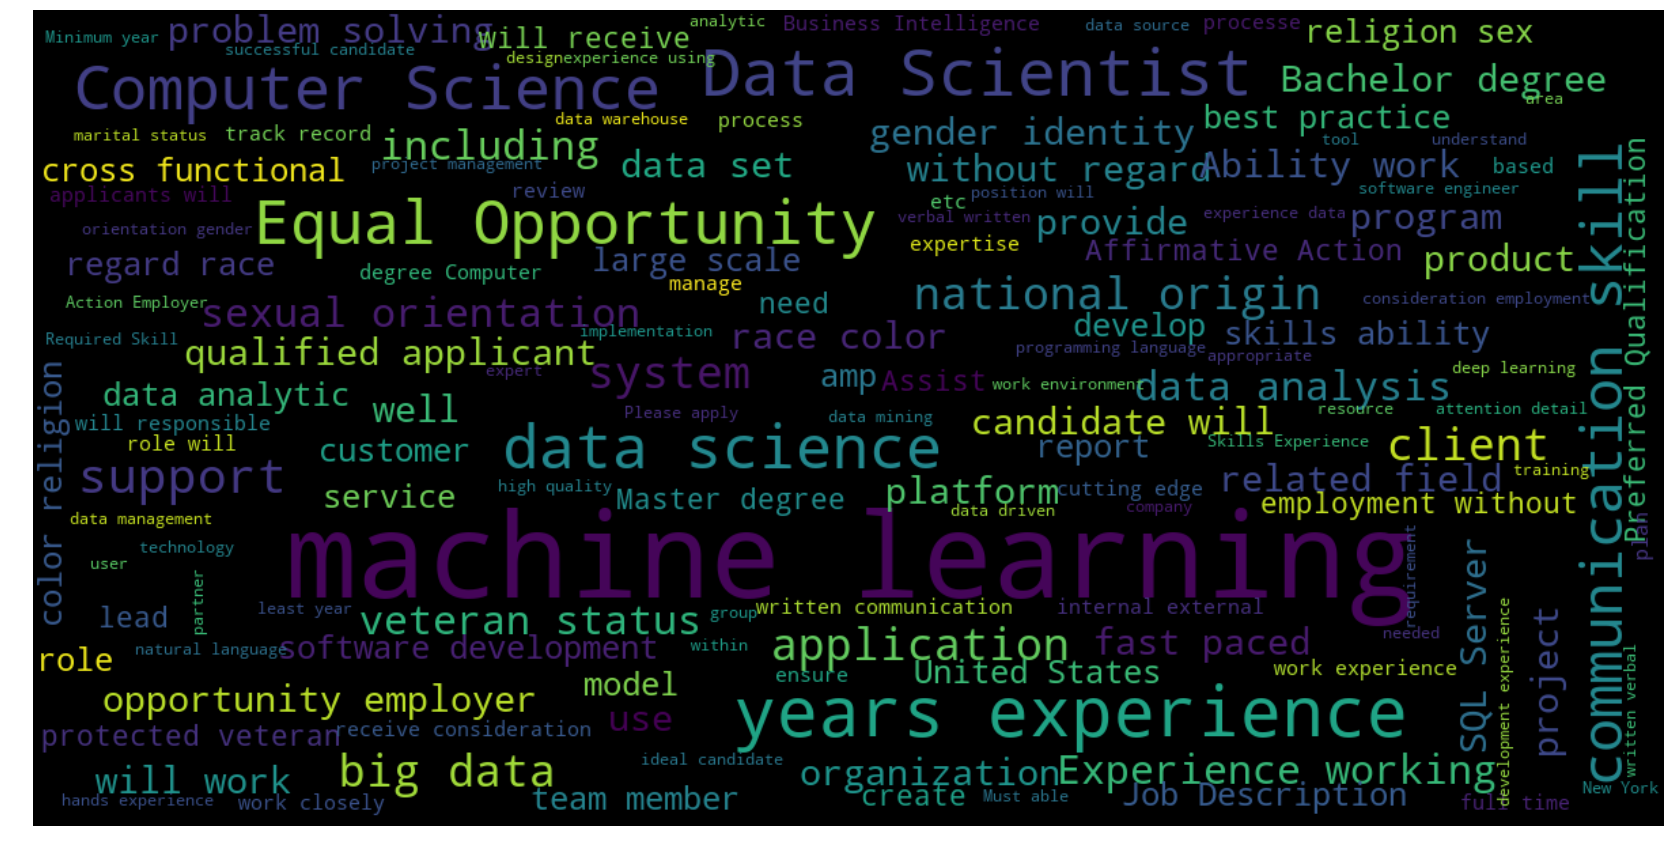

In [3]:
"""Generate a word cloud from description column"""
#create a long string from the description column to feed into wordcloud
desc = merged_dataset['Description']
desc = " ".join((str(x) for x in desc))
#create the wordcloud using the string and add formating for size
wordcloud = WordCloud(scale=3,relative_scaling=1).generate(desc)
plt.figure(figsize=wordcloud_size)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("graphs/DescWordCloud.jpg")
plt.show()

In [4]:
""" Creating an interactive Choropleth Graph to show distribution of jobs across the USA"""
# grouping the dataframe by state
desc = merged_dataset['Description']
#print(desc)
group_by_state = merged_dataset.groupby("Loc_state")
#getting the count of job positions by state
count_for_state = group_by_state.count()
count_for_state = count_for_state['Position']

# Import state list CSV
state_list = os.path.join('states.csv')
state_list_df = pd.read_csv(state_list)
# if no entry for a specific state then make a new entry for that state with 0 for no of jobs in that state
for item in state_list_df['Abbreviation']:
    if item not in count_for_state:
        count_for_state.at[item] = 0
#print(count_for_state)

# setting the location of the globe and the zoom value 
map = folium.Map(location=[40, -100], zoom_start=4.3)
# importing a json with state borders
state_geo = os.path.join('us-states.json')
# mapping the choropleth
map.choropleth(geo_data=state_geo,
 name='choropleth',
 data=count_for_state,
 columns=['Loc_state', ''],
 threshold_scale = [0, 25, 150, 600, 1400, 2500],
 key_on='feature.id',
 fill_color='BuPu',
 fill_opacity=0.7,
 line_color = 'blue',
 line_opacity=0.3,
 legend_name='Job distribution across the USA',
 smooth_factor = 1,
 highlight = True)
folium.LayerControl().add_to(map)
map.save('folium_choropleth_USA1.html')
map

FileNotFoundError: [Errno 2] No such file or directory: 'us-states.json'

In [ ]:
"""Generating graph of jobs at state level"""
#stripping spaces from the state column
merged_dataset["Loc_state"] = merged_dataset["Loc_state"].str.strip()
#grouped by state to create a bar graph and pie chart to get an idea of distribution of the jobs by state
group_by_state = merged_dataset.groupby("Loc_state")
#apply aggrigrate function of count to get number of count per state and remove the extra columns to end up with counters per state
count_for_state = group_by_state.count()
count_for_state = count_for_state["Position"]
count_for_state = count_for_state.to_frame()
count_for_state = count_for_state.reset_index()
#set index of loc state for setting axies for bar and pie
count_for_state = count_for_state.set_index("Loc_state")
#Loop to check against the 50 states of US, and drop non relevant ones
found = []
notfound = []
for item in count_for_state.index.values.tolist():
    try:
        if item in state_list_df['Abbreviation'].unique():
#            print(f"Found state: {item}")
            found.append(item)
        else:
            notfound.append(item)
#            print(f"{item} is not a US state.")
            count_for_state.drop(item, axis= 0,inplace = True)
#            print(f"Dropped entry for {item}")
    except:
        print("error occured")

#print(count_for_state)     
print(f"Found: {len(found)} of states")
print(f"Did not find:{notfound} and the corresponding entries have been removed")

#Printing the graph with desired parameters
count_for_state = count_for_state.sort_values("Position", ascending=False)
count_for_state.plot.bar(figsize=barchart_size,legend=False, color = color, zorder=2.5)
plt.xticks(rotation=90,size=fontvalue)
plt.yticks(size=fontvalue)
plt.title("Job Count by State")
plt.xlabel("States",size=fontvalue)
plt.ylabel("Count of Jobs",size=fontvalue)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y')
plt.tight_layout()
plt.savefig("graphs/BarOfCountofJobsUS.jpg")
plt.show()

In [ ]:
"""Generating graph to compare job count across top 10 cities"""
#grouping the dataframe by state and city
merged_dataset_stacked_bar_grouped = merged_dataset.groupby(["Loc_state","Loc_city"])
merged_dataset_stacked_bar_grouped_count = merged_dataset_stacked_bar_grouped.count()
merged_dataset_stacked_bar_grouped_count = merged_dataset_stacked_bar_grouped_count["Position"]
#sorting the data
merged_dataset_stacked_bar_grouped_count_sorted = merged_dataset_stacked_bar_grouped_count.sort_values(ascending=False)
#filtering for top 10 cities
merged_dataset_stacked_bar_grouped_count_sorted_head = merged_dataset_stacked_bar_grouped_count_sorted.head(10)
# plotting the graph with desired parameters
merged_dataset_stacked_bar_grouped_count_sorted_head.plot.bar(figsize=barchart_size,stacked=True, color=color,zorder=2.5)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y')
plt.xticks(rotation=90, size = fontvalue)
plt.yticks(size=fontvalue)
merged_dataset_stacked_bar_grouped_count_sorted_head
plt.title("Top 10 Cities across US",size = fontvalue)
plt.xlabel("States_City",size = fontvalue)
plt.ylabel("Count of Jobs",size = fontvalue)
plt.tight_layout()
plt.savefig("graphs/BarOfStateandCities.jpg")
plt.show()

In [ ]:
"""Grenerating a view of job count specifically in the state of California"""
# filtering data for CA
california_data_set = merged_dataset.loc[merged_dataset["Loc_state"] == "CA"]
# grouping of data by city name
california_data_set_grouped_by_city = california_data_set.groupby("Loc_city")
count_for_california = california_data_set_grouped_by_city.count()
count_for_california = count_for_california["Position"]
count_for_california = count_for_california.to_frame()
#sorting the dataframe
count_for_california = count_for_california.sort_values(["Position"], ascending=False )
# plotting the graph with desired parameters
count_for_california.plot.bar(figsize=(11.20*3,4*4),legend=False, color=color,zorder=2.5)
plt.xticks(rotation=90,size=fontvalue)
plt.yticks(size=fontvalue)
plt.title("Job Count in California Cities",size = fontvalue)
plt.xlabel("Cities",size = fontvalue )
plt.ylabel("Count of Jobs",size = fontvalue)
plt.grid(linestyle='-', linewidth='0.5', color='red',axis='y')
plt.tight_layout()
plt.savefig("graphs/BarOfCountofJobsCA.jpg")
plt.show()

In [ ]:
""" Geenrating a view of the jobs in top 10 cities in the state of California"""
# filtering top ten cities in CA that have most jobs
count_for_california_top10 = count_for_california[0:10]
# plotting the graph with desired parameters
count_for_california_top10.plot.bar(figsize=barchart_size,legend=False, color=color,zorder=2.5)
plt.xticks(rotation=90,size=fontvalue)
plt.yticks(size=fontvalue)
plt.title("Top 10 California Cities",size = fontvalue)
plt.xlabel("Cities",size = fontvalue )
plt.ylabel("Count of Jobs",size = fontvalue)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y',zorder=2.5)
plt.tight_layout()
plt.savefig("graphs/BarOfCountofJobsCA_top10.jpg")
plt.show()

In [ ]:
"""Generating a view into most popular skill, tool, education requirement for jobs"""

#Defining the skills, tools and education levels that we are interested in
skill_list =['data analysis','machine learning','statistics','computer science','communication','mathematics', 'visualization', 'ai',\
             'deep learning', 'nlp', 'software development','neural networks', 'project management', 'software engineering', \
              'data engineering','bi','modeling','etl','statistical analysis','research','deep learning','interpersonal skills',\
            'web scraping','neural network','decision tree','random forest','testing']
tool_list = ['python','r','sql','hadoop','spark','java','sas','tableau','hive','scala','aws','c++','matlab',\
             'c','excel','nosql','linux','vba','json','numpy','pandas','matplotlib','api','mysql','mongodb','html','css',\
             'java script','ajax','d3','leaflet','matlab']
edu_list = ['bachelor','bachelors','master','masters','phd','post graduation','graduation','high school','bs','ms','ba','ma']
level = ['senior','sr','manager','associate','lead','director','principal','architect','intern','program','assistant','management',\
 'junior','executive','jr','vp','president','chief','vice','mid','entry','student','mgr']

#combining the description, skills and positions to enable parsing
description = merged_dataset['Description']
skills = merged_dataset['Skills']
title = merged_dataset['Position']
desc_skills = description.append(skills)
parse_list = description.append(title)
skill_count = {}
tool_count = {}
edu_count = {}
no_edu_count = 0
#parsing the data to identify count for skills and tools
for entry in parse_list:
    try:
        # using regular expression to replace special characters and certain terms
        entry = re.sub('[./\n\r(),:-]', ' ', str(entry))
        entry = re.sub('[^A-Za-z0-9+ ]', '', str(entry)).lower()
        entry = re.sub('data analytics', 'data analysis', str(entry))
        entry = re.sub('artificial intelligence', 'ai', str(entry))
        # skill check while avoiding duplicates
        for skill in skill_list:
            if (f' {skill} ' in f' {entry} '):
                if skill not in skill_count:
                    skill_count[skill] = 1
                else:
                    skill_count[skill] += 1
        # tool check while avoiding duplicates
        for tool in tool_list:
            if f' {tool} ' in f' {entry} ':
                if tool not in tool_count:
                    tool_count[tool] = 1
                else:
                    tool_count[tool] += 1   
    except:
        print("Skipping an entry due to bad data")
        continue
# generating data set to look for education requirement
description2 = merged_dataset['Description']
#parsing the data to identify count for education
for item in description2:
    try:
        # using regular expression to replace special characters and certain terms
        item = re.sub('[./\n\r(),:-]', ' ', str(item))
        item = re.sub('[^A-Za-z0-9+ ]', '', str(item)).lower()
        item = re.sub('data analytics', 'data analysis', str(item))
        item = re.sub('artificial intelligence', 'ai', str(item))
        i = 0
        # tool check while avoiding duplicates and also counting entries that do NOT have education requirement
        for edu in edu_list:
            if f' {edu} ' in f' {item} ':
                if edu not in edu_count:
                    edu_count[edu] = 1
                else:
                    edu_count[edu] += 1 
            else:
                i +=1
        if i==12: 
            no_edu_count +=1
    except:
        print("Skipping an entry due to bad data")
        continue
print(skill_count)
print(tool_count)
print(edu_count)
# creating an education count data frame where like education counts are combined
education_count = {
    'High School':edu_count['high school'],
    'Bachelors':edu_count['bachelors']+edu_count['bachelor']+edu_count['graduation']+edu_count['bs']++edu_count['ba'],
    'Masters':edu_count['masters']+edu_count['master']+edu_count['post graduation']+edu_count['ms']++edu_count['ma'],
    'Phd':edu_count['phd'],
    'No education mentioned':no_edu_count
}
print(education_count)

In [ ]:
"""Generating a view into most popular skill required for jobs"""
#creating the skill count dataframe
skill_count_df = pd.DataFrame.from_dict(skill_count, orient='index').rename(columns={0:'Skill Count'}).sort_values(by=['Skill Count'], ascending =0)
# plotting the graph with desired parameters
plt.figure(figsize=(15,10))
plt.bar(range(len(skill_count_df)), skill_count_df["Skill Count"], color=color)
plt.xticks(range(len(skill_count_df)),list(skill_count.keys()),rotation=80)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y',zorder=2.5)
plt.title('Skill Demand',size = fontvalue)
plt.xlabel('Skill Name',size = fontvalue)
plt.ylabel('Skill Count',size = fontvalue)
plt.tight_layout()
plt.show()

# plotting a word cloud to compare wiht the graph above
plt.figure(figsize=wordcloud_size)
wordcloud = WordCloud(scale=3,relative_scaling=1).generate_from_frequencies(skill_count)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig("graphs/SkillsTargetedWordCloud.jpg")
plt.show()

In [ ]:
"""Generating a view into most popular tools required for jobs"""
#creating the tool count dataframe
tool_count_df = pd.DataFrame.from_dict(tool_count, orient='index').rename(columns={0:'Tool Count'}).sort_values(by=['Tool Count'], ascending =0)
# plotting the graph with desired parameters
plt.figure(figsize=(15,10))
plt.bar(range(len(tool_count_df)), tool_count_df["Tool Count"], color=color)
plt.xticks(range(len(tool_count_df)),list(tool_count.keys()),rotation=80)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y',zorder=2.5)
plt.title('Tool Demand',size = fontvalue)
plt.xlabel('Tool Name',size = fontvalue)
plt.ylabel('Tool Count',size = fontvalue)
plt.tight_layout()
plt.show()

# plotting a word cloud to compare wiht the graph above
plt.figure(figsize=wordcloud_size)
wordcloud = WordCloud(scale=3,relative_scaling=.5).generate_from_frequencies(tool_count)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig("graphs/ToolsTargetedWordCloud.jpg")
plt.show()

In [ ]:
"""Generating a view into most popular education level required for jobs"""
#creating the education requriement dataframe
education_count_df = pd.DataFrame.from_dict(education_count, orient='index').rename(columns={0:'Education Requirement'})
# plotting the graph with desired parameters
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', 'yellow']
explode = (0.05,0.05,0.05,0.05,0.05)
ax = education_count_df.plot(kind='pie',y =['Education Requirement'], autopct='%1.1f%%',startangle=360, shadow=False,\
                        labels=education_count_df.index, colors=colors, explode=explode, pctdistance=0.85,\
                            labeldistance=1.05)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
ax.get_legend().remove()
plt.tight_layout()
plt.show()

In [ ]:
"""Generating a view into most popular job types and job levels"""
# defining a function to idetify word count
def parser(column):
    word_count = {}
    for entry in column:
        entry = re.sub('[^A-Za-z0-9 ]+', '', str(entry))
        try:
            entry = entry.replace(',','')
            entry = re.sub('[^A-Za-z0-9+ ]', '', str(entry)).lower()
            word_split = entry.split()
            for word in word_split:
                if word not in word_count:
                    word_count[word] = 1
                else:
                    word_count[word] += 1
        except AttributeError:
            print("Skipping an entry due to bad data")
            continue

#using a package to identify most common words from the parsed data
from collections import Counter
parse_pos = parser(title)
# #parse_pos
d = Counter(parse_pos)
x = d.most_common()

#defining the job types based on most popular and common job type occurences in the title / job posting
job_type = ['administrator','tester','coordinator','designer','engineer','modeler',\
           'researcher','system analyst','analyst','scientist','developer']

#defining the job levels based on most popular and common job level occurences in the title / job posting
job_level = ['senior','midlevel','junior']

job_type_count = {}
job_level_count = {}
#parsing the title to identify job adn job level counts
for entry in title:
   try:
       #substituting job_types with meaningful names
       entry = re.sub('[./\n\r(),:-]', ' ', str(entry))
       entry = re.sub('[^A-Za-z0-9+ ]', '', str(entry)).lower()
       entry = re.sub('(admin)', 'administrator', str(entry))
       entry = re.sub('(analysis|analytical|analytics)', 'analyst', str(entry))
       entry = re.sub('(design)', 'designer', str(entry))
       entry = re.sub('(dev|developers|devops|programmer)', 'developer', str(entry))
       entry = re.sub('(engineering|engineerscientist)', 'engineer', str(entry))
       entry = re.sub('(modeler)', 'modeler', str(entry))
       entry = re.sub('(research)', 'researcher', str(entry))
       entry = re.sub('(science|sciences|scientific|scientistengineer)', 'scientist', str(entry))
       entry = re.sub('(system|systems)', 'system analyst', str(entry))
       entry = re.sub('(automation|qa)', 'tester', str(entry))
       #substituting job levels with meaningful names
       entry = re.sub('(associate|intern|assistant|jr|assistant|entry|student)', 'junior', str(entry))
       entry = re.sub('(manager|lead|architect|program|mid|manager|mgr)', 'midlevel', str(entry))
       entry = re.sub('(sr|director|principal|executive|vp|president|chief|vice)', 'senior', str(entry))
       #parsing each title to identify the job level associated to it
       for type in job_type:
           if (f' {type} ' in f' {entry} '):
               if type not in job_type_count:
                   job_type_count[type] = 1
               else:
                   job_type_count[type] += 1
               for level in job_level:
                   if f' {level} ' in f' {entry} ':
                       job_type_level = type+'_'+level
                       if job_type_level not in job_level_count:
                           job_level_count[job_type_level] = 1
                       else:
                           job_level_count[job_type_level] += 1
   except:
       print("Skipping an entry due to bad data")
       continue
print(job_type_count)
print(job_level_count)

In [ ]:
"""Generating a stacked bar graph to visualize the popular job types and the job levels within each type"""
# defining the base data frame
stack_bar_frame =pd.DataFrame({"Job":[],
                               "senior":[],
                              "midlevel":[],
                              "junior":[]})
# Parsing the job type and job levels to identify a count for each one so it can be appended to the base dataframe
for job in job_type_count:
    senior_count = 0
    midlevel_count = 0
    junior_count = 0    
    for lvl in job_level_count:
        # split the job_level entry by delimiter '_'
        to_check = lvl.split("_")
        # identify mid level, senior or junior level for the job and obtain the count and assign to a variable
        if job == to_check[0]:
            if to_check[1] == "midlevel":
                midlevel_count = job_level_count[lvl]
            if to_check[1] == "junior":
                junior_count = job_level_count[lvl]
            if to_check[1] == "senior":
                senior_count = job_level_count[lvl]     
    #create the list of values to append to the data frame
    toappend={"Job":job,
              "senior":senior_count,
              "midlevel":midlevel_count,
              "junior":junior_count}
    # append the value (row) to the data frame
    stack_bar_frame = stack_bar_frame.append(toappend,ignore_index=True)
print(stack_bar_frame)

# manupulate the dataframe to make it suitable for a stacked bar graph
job_type_count_frame = pd.DataFrame.from_dict([job_type_count]).T.reset_index()
job_type_count_frame = job_type_count_frame.rename(columns={0:"Total","index":"Job"})
# perform a join between the base dataframe and the new data frame to obtain the count of the total jobs for each job type
stacked_bar_merged_frame = job_type_count_frame.merge(stack_bar_frame, how="inner", on="Job")
# add a new column calle 'other' and calcualte its value as difference between total count and sum of junior, senior and midlevel
stacked_bar_merged_frame["other"] = stacked_bar_merged_frame["Total"] - (stacked_bar_merged_frame["senior"]+stacked_bar_merged_frame["midlevel"]+stacked_bar_merged_frame["junior"])
# convert the columns to an int
stacked_bar_merged_frame[["senior","midlevel","junior","Total"]].astype(int)
# set the index to jobs
stacked_bar_merged_frame = stacked_bar_merged_frame.set_index("Job")
# sorting of data
stacked_bar_merged_frame = stacked_bar_merged_frame.sort_values(by="Total", ascending= False)
# removing non-essential columns like total count from the data frame
stacked_bar_merged_frame = stacked_bar_merged_frame[["senior","midlevel","junior","other"]]
# plotting of data based on desited parameters
stacked_bar_merged_frame.plot.bar(figsize=barchart_size,stacked = True, colormap="Blues")
plt.tight_layout()
plt.xticks(rotation=90,size=fontvalue)
plt.yticks(size=fontvalue)
plt.xlabel("Job Title",size = fontvalue)
plt.ylabel("Count", size = fontvalue)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y',zorder=2.5)
plt.tight_layout()
plt.legend(fontsize = fontvalue)
plt.savefig("graphs/StackedBarOfJobTypesTop4.jpg")
plt.show()

In [ ]:
#Creating a data fram with just the bottom 7 enteries as they are outliers in the graph above
stacked_bar_merged_frame_bottom = stacked_bar_merged_frame.tail(7)
# plotting of data based on desited parameters
stacked_bar_merged_frame_bottom.plot.bar(figsize=barchart_size,stacked = True,colormap="Blues")
plt.xticks(rotation=90,size=fontvalue)
plt.yticks(size=fontvalue)
plt.grid(linestyle='-', linewidth='0.5', color='red', axis='y',zorder=2.5)
plt.xlabel("Job Title",size = fontvalue)
plt.ylabel("Count", size = fontvalue)
plt.tight_layout()
plt.legend(fontsize = fontvalue)
plt.savefig("graphs/StackedBarOfJobTypessmallgroup.jpg")
plt.show()

In [ ]:
"""Generating a view of the top 10 companies and the number of jobs being offered"""
# grouping of data by company name
grp_company= merged_dataset.groupby('Company')
grp_compmny_count = pd.DataFrame(grp_company['Position'].count()).sort_values(by=['Position'], ascending=0)
# filtering top 10 companies
grp_compmny_count_10 =  grp_compmny_count.iloc[0:10,:]
print(grp_compmny_count_10)

# plotting of data based on desited parameters
plt.figure(figsize=(11,7))
grp_compmny_count_10_2 = grp_compmny_count_10.reset_index()
y = np.random.uniform(0,100,size=(1, 10))
x = np.random.uniform(0,100,size=(1, 10))
colors=plt.cm.Paired(np.arange(len(grp_compmny_count_10)))
ax = plt.scatter(x=x,y=y,color=colors, \
            s=50*grp_compmny_count_10['Position'],alpha=0.5, label=None)
i=0
for item in grp_compmny_count_10.index:
    plt.scatter([], [], color=colors[i], alpha=0.3, \
                s=grp_compmny_count_10.loc[item,['Position']], label=str(item))
    i+=1
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='', loc='upper right', fontsize='large')
plt.xlim(np.min(x)-10,np.max(x)+20)
plt.ylim(np.min(y)-10,np.max(y)+20)
plt.title("Top 10 companies offering jobs")
plt.tight_layout()
plt.show()